In [321]:
import SimpleITK as sitk
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from ipywidgets import interact
from ipywidgets.widgets import IntSlider
import cv2
import ants as ants
import matplotlib.pyplot as plt
import pydicom
from matplotlib.colors import ListedColormap
import os
from scipy import ndimage
import ImageTool.tool as tool
import PerfusionImaging.tool as perfusion
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import pandas as pd

In [322]:
target = "08_22_22_data/Pig2"
rest_sample = "Acq_01_Baseline"
stress_sample = "Acq_03_Stress"
save_path = os.path.join("/home/molloi-lab-linux2/smb_mount/ImageData/Myocardial_Perfusion/High_Fat_Diet/QYZ", target)
path_rest = os.path.join(save_path, rest_sample, "DICOM/02")
path_stress = os.path.join(save_path, stress_sample, "DICOM/02")
lmmask_path_rest = os.path.join(save_path, rest_sample, "SEGMENT_dcm/LEFT_MYOCARDIUM_dcm")
lmmask_path_stress = os.path.join(save_path, stress_sample, "SEGMENT_dcm/LEFT_MYOCARDIUM_dcm")
aorta_rest_mask = os.path.join(save_path, rest_sample, "SEGMENT_dcm/AORTA_dcm")
aorta_stress_mask = os.path.join(save_path, stress_sample, "SEGMENT_dcm/AORTA_dcm")
bolus_rest = os.path.join(save_path, rest_sample, "SureStart")
bolus_stress = os.path.join(save_path, stress_sample, "SureStart")

In [323]:
mask_rest_left = tool.load_2d_3d(lmmask_path_rest) 
mask_rest_right = tool.load_2d_3d(lmmask_path_rest.replace("LEFT", "RIGHT")) 
full_rest_mask = perfusion.mask_fun(sitk.GetArrayFromImage(mask_rest_left)) | perfusion.mask_fun(sitk.GetArrayFromImage(mask_rest_right))
full_rest_image = sitk.GetImageFromArray(full_rest_mask)
full_rest_image.CopyInformation(mask_rest_left)

mask_stress_left = tool.load_2d_3d(lmmask_path_stress) 
mask_stress_right = tool.load_2d_3d(lmmask_path_stress.replace("LEFT", "RIGHT")) 
full_stress_mask = perfusion.mask_fun(sitk.GetArrayFromImage(mask_stress_left)) | perfusion.mask_fun(sitk.GetArrayFromImage(mask_stress_right))
full_stress_image = sitk.GetImageFromArray(full_stress_mask)
full_stress_image.CopyInformation(mask_stress_left)


In [324]:
save_files = os.path.join("/home/molloi-lab-linux2/Desktop/ZQY/Project perfusion/Alireza", target)
tool.make_if_dont_exist(save_files)
tool.load_2d_3d(path_rest, save_files + "/rest.nii")
tool.load_2d_3d(path_stress, save_files + "/stress.nii")
sitk.WriteImage(full_rest_image, save_files + "/full_rest_mask.nii")
sitk.WriteImage(full_stress_image, save_files + "/full_stress_mask.nii")
tool.load_2d_3d(aorta_rest_mask, save_files + "/aorta_rest.nii")
tool.load_2d_3d(aorta_stress_mask, save_files + "/aorta_stress.nii")
tool.load_2d_3d(bolus_rest, save_files + "/bolus_rest.nii")
tool.load_2d_3d(bolus_stress, save_files + "/bolus_stress.nii")


<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x71a477f9a6c0> >

In [325]:
dcm_stress = ants.image_read(save_files + "/stress.nii")
dcm_rest = ants.image_read(save_files + "/rest.nii")
dcm_mask_rest = ants.image_read(save_files + "/full_rest_mask.nii")
dcm_mask_stress = ants.image_read(save_files + "/full_stress_mask.nii") 
dcm_rest_aorta = ants.image_read(save_files + "/aorta_rest.nii") 
dcm_stress_aorta = ants.image_read(save_files + "/aorta_stress.nii") 

In [326]:
rest_value = np.sum(dcm_rest[:] * perfusion.mask_fun(dcm_rest_aorta[:]))/np.sum(perfusion.mask_fun(dcm_rest_aorta[:]))
stress_value = np.sum(dcm_stress[:] * perfusion.mask_fun(dcm_stress_aorta[:]))/np.sum(perfusion.mask_fun(dcm_stress_aorta[:]))
np.save(save_files + "/value.npy", np.array([rest_value, stress_value]))

In [327]:
def plot_slice1(slice_index):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    current_slice_index = slice_index  # Update the global variable

    ax1.imshow(dcm_rest[:, :, slice_index], cmap='gray', vmin=0, vmax=500)
    ax1.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha= 0.5)
    # ax1.imshow(dcm_rest_aorta[:, :, slice_index], cmap=ListedColormap(['black', 'green']),  vmin=0, vmax=1, alpha = 0.7)

    ax2.imshow(dcm_stress[:, :, slice_index], cmap='gray', vmin=0, vmax=500)
    ax2.imshow(dcm_mask_stress[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha= 0.5)
    ax2.set_title("reg_stress scan")

    plt.show()

# Creating an interactive slider
interact(plot_slice1, slice_index=IntSlider(min=0, max=dcm_mask_rest.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice1(slice_index)>

In [328]:
method = ants.registration(fixed=dcm_mask_rest , moving=dcm_mask_stress, type_of_transform ='SyNAggro')
reg_stress = ants.apply_transforms(fixed=dcm_rest, moving=dcm_stress, transformlist=method['fwdtransforms'])
# reg_stress = ants.registration(fixed=dcm_rest, moving=dcm_stress, moving_mask = dcm_lmmask_stress, mask = dcm_lmmask_rest, type_of_transform ='SyNAggro')["warpedmovout"].numpy()

In [329]:
def plot_slice2(slice_index):
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 6))
    current_slice_index = slice_index  # Update the global variable
    pcm = ax1.imshow(dcm_mask_stress[:, :, slice_index], cmap=ListedColormap(['black', 'green']),  vmin=0, vmax=1, alpha = 1)
    ax1.imshow(dcm_mask_rest[: , :, slice_index], cmap='jet', vmin=0, vmax=1, alpha = 0.5)
    ax1.set_title("rest scan")
    pcm3 = ax3.imshow(method["warpedmovout"][:, :, slice_index], cmap=ListedColormap(['black', 'green']), vmin=0, vmax=1)
    ax3.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha = 0.5)
    ax3.set_title("dcm_stress")
    plt.show()

# Creating an interactive slider
interact(plot_slice2, slice_index=IntSlider(min=0, max=dcm_mask_stress.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice2(slice_index)>

In [330]:
def plot_slice3(slice_index):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 5))
    current_slice_index = slice_index  # Update the global variable
    pcm = ax0.imshow(abs(reg_stress[:, :, slice_index] - dcm_rest[:, :, slice_index]), cmap='jet', vmin=0, vmax=500)
    ax0.set_title("rest")

    pcm = ax1.imshow(dcm_rest[:, :, slice_index] * dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=500)
    ax1.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha=0)
    ax1.set_title("Rest")
    pcm2 = ax2.imshow(reg_stress[:, :, slice_index], cmap='jet', vmin=0, vmax=500)
    ax2.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha=0.5)
    ax2.set_title("Register")
    pcm3 = ax3.imshow(dcm_stress[:, :, slice_index], cmap='jet', vmin=0, vmax=500)
    ax3.imshow(dcm_mask_stress[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha=0.5)
    ax3.set_title("Stress")
    plt.show()

# Creating an interactive slider
interact(plot_slice3, slice_index=IntSlider(min=0, max=reg_stress.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice3(slice_index)>

In [331]:
ants.image_write(reg_stress, save_files + "/reg_stress.nii")

In [332]:
path_rest

'/home/molloi-lab-linux2/smb_mount/ImageData/Myocardial_Perfusion/High_Fat_Diet/QYZ/08_22_22_data/Pig2/Acq_01_Baseline/DICOM/02'

In [333]:
time_v2 = perfusion.scan_time_vector([os.path.join(path_rest, i) for i in os.listdir(path_rest)])
time_ss = perfusion.scan_time_vector([os.path.join(bolus_rest, i) for i in os.listdir(bolus_rest)])
time_vec_gamma_rest = time_ss + [time_v2[len(time_v2)//2]]
time_vec_gamma_rest = [i - time_vec_gamma_rest[0] for i in time_vec_gamma_rest]

time_v2 = perfusion.scan_time_vector([os.path.join(path_stress, i) for i in os.listdir(path_stress)])
time_ss = perfusion.scan_time_vector([os.path.join(bolus_stress, i) for i in os.listdir(bolus_stress)])
time_vec_gamma_stress = time_ss + [time_v2[len(time_v2)//2]]
time_vec_gamma_stress = [i - time_vec_gamma_stress[0] for i in time_vec_gamma_stress]

In [334]:
ss_rest = ants.image_read(save_files + "/bolus_rest.nii")[:]
first_slice_rest = ants.image_read(save_files + "/bolus_rest.nii")[:,:,0]
ss_stress = ants.image_read(save_files + "/bolus_stress.nii")[:]
first_slice_stress = ants.image_read(save_files + "/bolus_rest.nii")[:,:,0]
ss_rest_value = [0] * (ss_rest.shape[0] + 1)
ss_rest_value[-1] = np.load(save_files + "/value.npy")[0]
ss_stress_value = [0] * (ss_stress.shape[0] + 1)
ss_stress_value[-1] = np.load(save_files + "/value.npy")[1]
input_conc = [0, 0]
auc_area = [0, 0]

In [335]:
def plot_slice4(slice_index, x, y, r):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

    pcm = ax0.imshow(ss_rest[:, :, slice_index], cmap='gray', vmin=0, vmax=300)
    ax0.set_title("rest")
    phi = np.linspace(0, 2 * np.pi, 100)
    circle_x = r * np.cos(phi) + x
    circle_y = r * np.sin(phi) + y
    ax0.plot(circle_x, circle_y, label=f"Aorta Mask (radius {r})", color="red", linewidth=1)
    ss_rest_value[:-1] = perfusion.compute_aif(ss_rest, x, y, r)
    # Add legend
    ax0.legend()
    try:
        baseline_hu = np.mean(ss_rest_value[:3])
        p0 = [0.0, baseline_hu]  # Initial guess (0, blood pool offset)

        time_vec_end, aif_vec_end = time_vec_gamma_rest[-1], ss_rest_value[-1]
        opt_params = perfusion.gamma_curve_fit(time_vec_gamma_rest, ss_rest_value, time_vec_end, aif_vec_end, p0)
        x_fit = np.linspace(np.min(time_vec_gamma_rest), np.max(time_vec_gamma_rest), 500)

        y_fit = perfusion.gamma(x_fit, opt_params, time_vec_end, aif_vec_end)
        
        baseline_hu = y_fit[0]

        # Adjust y values by subtracting baseline and taking max(0, y)
        dense_y_fit_adjusted = np.maximum(y_fit - baseline_hu, 0)

        # Compute the area under the curve using trapezoidal integration
        area_under_curve = trapezoid(dense_y_fit_adjusted, x_fit)
        # Generate a dense time vector
        # Compute input concentration
        input_conc[0] = area_under_curve  # Adjust for Python indexing (0-based)
        ax1.set_title("Fitted AIF Curve")
        ax1.set_xlabel("Time Point (s)")
        ax1.set_ylabel("Intensity (HU)")

        # Plot the scatter points
        ax1.scatter(time_vec_gamma_rest, ss_rest_value, label="Data Points", color="blue")

        # Plot the fitted curve
        ax1.plot(x_fit, y_fit, label="Fitted Curve", color="red")

        # Highlight specific points
        ax1.scatter(time_vec_gamma_rest[-2], ss_rest_value[-2], label="Trigger", color="green")
        ax1.scatter(time_vec_gamma_rest[-1], ss_rest_value[-1], label="V2", color="orange")

        # Add legend
        ax1.legend(loc="upper left")

        # Generate AUC plot
        time_temp = np.linspace(time_vec_gamma_rest[0], time_vec_gamma_rest[-1], int(np.max(time_vec_gamma_rest) * 1))
        auc_area[0] = perfusion.gamma(time_temp, opt_params, time_vec_end, aif_vec_end) - baseline_hu

        # Create a denser AUC plot
        n_points = 1000  # Number of points for denser interpolation
        time_temp_dense = np.linspace(time_temp[0], time_temp[-1], n_points)
        auc_area_dense = perfusion.gamma(time_temp_dense, opt_params, time_vec_end, aif_vec_end) - baseline_hu

        # Add vertical lines for AUC visualization
        for i in range(len(auc_area_dense)):
            ax1.plot(
                [time_temp_dense[i], time_temp_dense[i]],
                [baseline_hu, auc_area_dense[i] + baseline_hu],
                color="cyan",
                linewidth=1,
                alpha=0.2
            )
        np.save("rest_para.npy", [x, y, r])
    except:
        pass
    # Show the plot
    plt.show()

# Creating an interactive slider
if os.path.exists("rest_para.npy"):
    x, y, r = np.load("rest_para.npy")
else:
    x, y, r = 0, 0, 8
interact(plot_slice4, slice_index=IntSlider(max=ss_rest.shape[2] - 1), x = IntSlider(min = 15, max = ss_rest.shape[0] - 15, value = x), y = IntSlider(min = 15, max = ss_rest.shape[1] - 15, value = y), r = IntSlider(max = 14, value = r))

interactive(children=(IntSlider(value=0, description='slice_index', max=26), IntSlider(value=247, description=…

<function __main__.plot_slice4(slice_index, x, y, r)>

The slice number of 180 is chosen
52.262512 59.73929


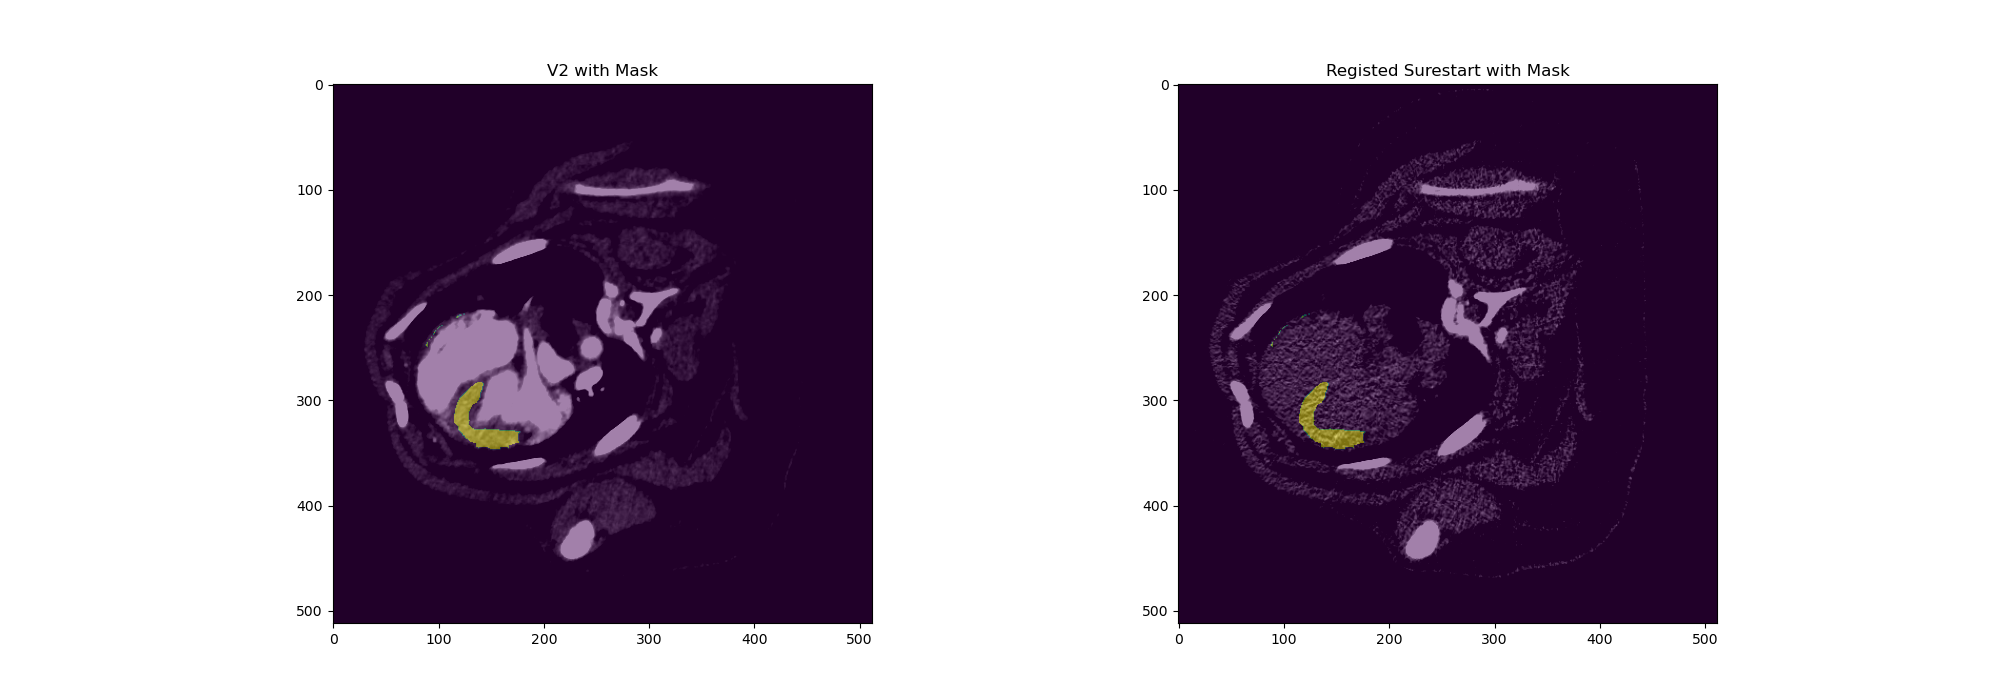

In [336]:
HU_sure_mean = perfusion.calculate_mean_hu(dcm_rest, dcm_mask_rest, first_slice_rest, erode_size = 1, visual=True)
v1_arr = dcm_rest.copy()
v1_arr[dcm_mask_rest] = np.round(HU_sure_mean)
print(HU_sure_mean, np.mean(dcm_rest[dcm_mask_rest]))

In [337]:
result_rest = perfusion.compute_organ_metrics(dcm_rest, dcm_mask_rest, HU_sure_mean, time_vec_gamma_rest, input_conc[0], tissue_rho=1.053)

In [342]:
col_vals = [result_rest["perf"], result_rest["perf_std"], result_rest["flow"], result_rest["flow_std"],  result_rest["delta_time"], result_rest["organ_mass"], result_rest["heart_rate"]]
col_names = ["perfusion", "perfusion_std", "flow", "flow_std", "delta_time", "mass", "heart_rate"]
df = pd.DataFrame({"parameters": col_names, "values": col_vals})
np.save(save_files + '/rest_result.npy', df.to_numpy())
df

,parameters,values
0,perfusion,0.447361
1,perfusion_std,1.720439
2,flow,13.254240
3,flow_std,50.972481
4,delta_time,13.095000
5,mass,29.627598
6,heart_rate,124.000000


In [339]:
def plot_slice5(slice_index, x, y, r):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

    # plt.figure(figsize=(5, 5))
    pcm = ax0.imshow(ss_stress[:, :, slice_index], cmap='gray', vmin=0, vmax=300)
    ax0.set_title("stress")
    phi = np.linspace(0, 2 * np.pi, 100)
    circle_x = r * np.cos(phi) + x
    circle_y = r * np.sin(phi) + y
    ax0.plot(circle_x, circle_y, label=f"Aorta Mask (radius {r})", color="red", linewidth=1)
    ss_stress_value[:-1] = perfusion.compute_aif(ss_stress, x, y, r)
    # Add legend
    ax0.legend()
    try:
        baseline_hu = np.mean(ss_stress_value[:3])
        p0 = [0.0, baseline_hu]  # Initial guess (0, blood pool offset)

        time_vec_end, aif_vec_end = time_vec_gamma_stress[-1], ss_stress_value[-1]

        opt_params = perfusion.gamma_curve_fit(time_vec_gamma_stress, ss_stress_value, time_vec_end, aif_vec_end, p0)
        x_fit = np.linspace(np.min(time_vec_gamma_stress), np.max(time_vec_gamma_stress), 500)

        y_fit = perfusion.gamma(x_fit, opt_params, time_vec_end, aif_vec_end)
        baseline_hu = y_fit[0]

        # Adjust y values by subtracting baseline and taking max(0, y)
        dense_y_fit_adjusted = np.maximum(y_fit - baseline_hu, 0)

        # Compute the area under the curve using trapezoidal integration
        area_under_curve = trapezoid(dense_y_fit_adjusted, x_fit)
        # Generate a dense time vector
        # Compute input concentration
        input_conc[1] = area_under_curve  # Adjust for Python indexing (0-based)

        ax1.set_title("Fitted AIF Curve")
        ax1.set_xlabel("Time Point (s)")
        ax1.set_ylabel("Intensity (HU)")

        # Plot the scatter points
        ax1.scatter(time_vec_gamma_stress, ss_stress_value, label="Data Points", color="blue")

        # Plot the fitted curve
        ax1.plot(x_fit, y_fit, label="Fitted Curve", color="red")

        # Highlight specific points
        ax1.scatter(time_vec_gamma_stress[-2], ss_stress_value[-2], label="Trigger", color="green")
        ax1.scatter(time_vec_gamma_stress[-1], ss_stress_value[-1], label="V2", color="orange")

        # Add legend
        ax1.legend(loc="upper left")

        # Generate AUC plot
        time_temp = np.linspace(time_vec_gamma_stress[2], time_vec_gamma_stress[-1], int(np.max(time_vec_gamma_stress) * 1))
        auc_area[1] = perfusion.gamma(time_temp, opt_params, time_vec_end, aif_vec_end) - baseline_hu

        # Create a denser AUC plot
        n_points = 1000  # Number of points for denser interpolation
        time_temp_dense = np.linspace(time_temp[0], time_temp[-1], n_points)
        auc_area_dense = perfusion.gamma(time_temp_dense, opt_params, time_vec_end, aif_vec_end) - baseline_hu

        # Add vertical lines for AUC visualization
        for i in range(len(auc_area_dense)):
            ax1.plot(
                [time_temp_dense[i], time_temp_dense[i]],
                [baseline_hu, auc_area_dense[i] + baseline_hu],
                color="cyan",
                linewidth=1,
                alpha=0.2
            )
        np.save("stress_para.npy", [x, y, r])
    except:
        pass
    # Show the plot
    plt.show()

# Creating an interactive slider
if os.path.exists("stress_para.npy"):
    x, y, r = np.load("stress_para.npy")
else:
    x, y, r = 0, 0, 8
interact(plot_slice5, slice_index=IntSlider(max=ss_stress.shape[2] - 1), x = IntSlider(min = 15, max = ss_stress.shape[0] - 15, value = x), y = IntSlider(min = 15, max = ss_stress.shape[1] - 15, value = y), r = IntSlider(max = 14, value = r))

interactive(children=(IntSlider(value=0, description='slice_index', max=39), IntSlider(value=413, description=…

<function __main__.plot_slice5(slice_index, x, y, r)>

The slice number of 197 is chosen
88 122.91797


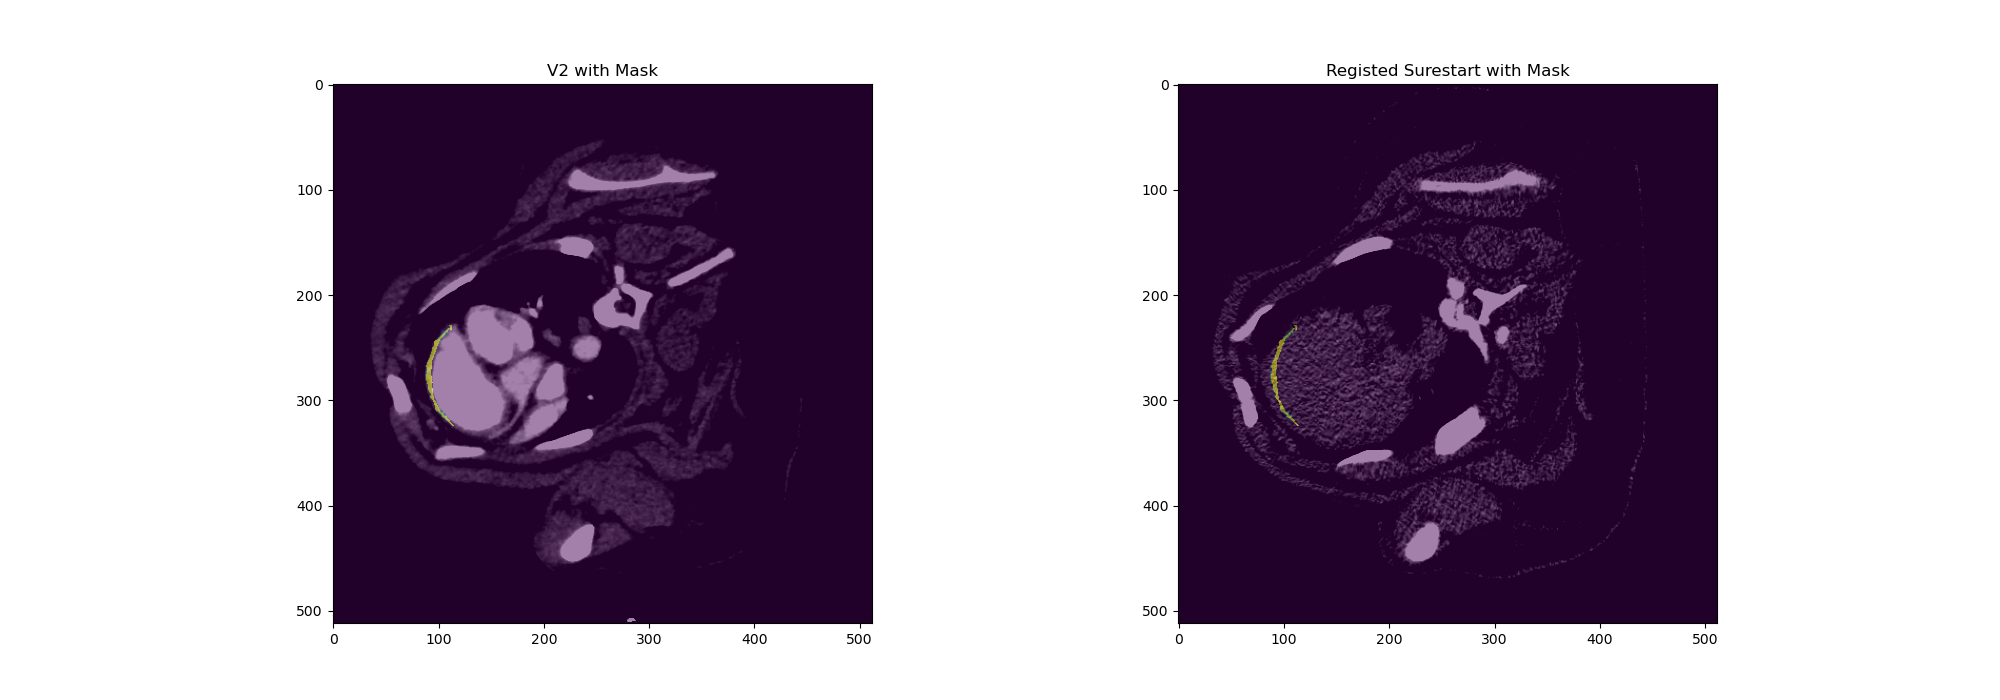

In [351]:
HU_sure_mean_stress = perfusion.calculate_mean_hu(dcm_stress, dcm_mask_stress, first_slice_stress, erode_size = 0, visual = True)
HU_sure_mean_stress = 88
v1_stress = reg_stress.copy()
v1_stress[dcm_mask_rest] = np.round(HU_sure_mean_stress)
print(HU_sure_mean_stress, np.mean(reg_stress[dcm_mask_rest]))

In [352]:
result_stress = perfusion.compute_organ_metrics(reg_stress, dcm_mask_rest, HU_sure_mean_stress, time_vec_gamma_stress, input_conc[1], tissue_rho=1.053)

In [353]:
col_vals = [result_stress["perf"], result_stress["perf_std"], result_stress["flow"], result_stress["flow_std"],  result_stress["delta_time"], result_stress["organ_mass"], result_stress["heart_rate"]]
col_names = ["perfusion", "perfusion_std", "flow", "flow_std", "delta_time", "mass", "heart_rate"]
df = pd.DataFrame({"parameters": col_names, "values": col_vals})
# Save the NumPy array to a .npy file
np.save(save_files + '/stress_result.npy', df.to_numpy())
df

,parameters,values
0,perfusion,3.439221
1,perfusion_std,2.798419
2,flow,101.895847
3,flow_std,82.910439
4,delta_time,17.118000
5,mass,29.627598
6,heart_rate,140.000000


In [355]:
CFR = result_stress["perf"]/result_rest["perf"]
CFR

7.687792599637285

In [356]:
CFR_map = result_stress["perf_map"]/(result_rest["perf_map"] + 0.1)

In [357]:
def plot_slice6(slice_index):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    current_slice_index = slice_index  # Update the global variable

    ax1.imshow(CFR_map[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha = 0.5)
    ax1.set_title("cfr scan")
    
    pcm2 = ax2.imshow(result_stress["perf_map"][:, :, slice_index], cmap='jet', vmin=0, vmax=3)
    ax2.set_title("perfusion_stress scan")
    
    pcm3 = ax3.imshow(result_rest["perf_map"][:, :, slice_index], cmap='jet', vmin=0, vmax=3)
    ax3.set_title("perfusion_rest")
    plt.show()

# Creating an interactive slider
interact(plot_slice6, slice_index=IntSlider(min=0, max=dcm_mask_stress.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice6(slice_index)>

In [358]:
def find_bounding_box(mask, offset=(0, 0, 0)):
    dims = mask.shape
    non_zero_indices = np.argwhere(mask)

    if non_zero_indices.size == 0:
        return None  # Return None if the mask is empty

    # Compute min and max for each dimension
    min_x = max(0, np.min(non_zero_indices[:, 0]) - offset[0])
    max_x = min(dims[0] - 1, np.max(non_zero_indices[:, 0]) + offset[0]) + 1

    min_y = max(0, np.min(non_zero_indices[:, 1]) - offset[1])
    max_y = min(dims[1] - 1, np.max(non_zero_indices[:, 1]) + offset[1]) + 1

    min_z = max(0, np.min(non_zero_indices[:, 2]) - offset[2])
    max_z = min(dims[2] - 1, np.max(non_zero_indices[:, 2]) + offset[2]) + 1

    # Validate bounding box
    if min_x > dims[0] - 1 or max_x < 0 or min_y > dims[1] - 1 or max_y < 0 or min_z > dims[2] - 1 or max_z < 0:
        raise ValueError("Offset is too large, resulting in an invalid bounding box.")

    return min_x, max_x, min_y, max_y, min_z, max_z
def crop_array(array, box):
    return array[box[0]:box[1], box[2]:box[3], box[4]:box[5]]

In [359]:
CFR_map_new = CFR_map.copy()
CFR_map_new[CFR_map_new > 10] = 10
CFR_map_new = ants.from_numpy(CFR_map_new, origin=dcm_mask_rest.origin, spacing=dcm_mask_rest.spacing, direction=dcm_mask_rest.direction)
pref_rest_new = ants.from_numpy(result_rest["perf_map"], origin=dcm_mask_rest.origin, spacing=dcm_mask_rest.spacing, direction=dcm_mask_rest.direction)
pref_stress_new = ants.from_numpy(result_stress["perf_map"], origin=dcm_mask_rest.origin, spacing=dcm_mask_rest.spacing, direction=dcm_mask_rest.direction)
# Step 3: Save the new image with updated metadata
ants.image_write(CFR_map_new, save_files + "/CFR_with_headers.nii")
ants.image_write(pref_rest_new, save_files + "/pref_rest.nii")
ants.image_write(pref_stress_new, save_files + "/pref_stress.nii")

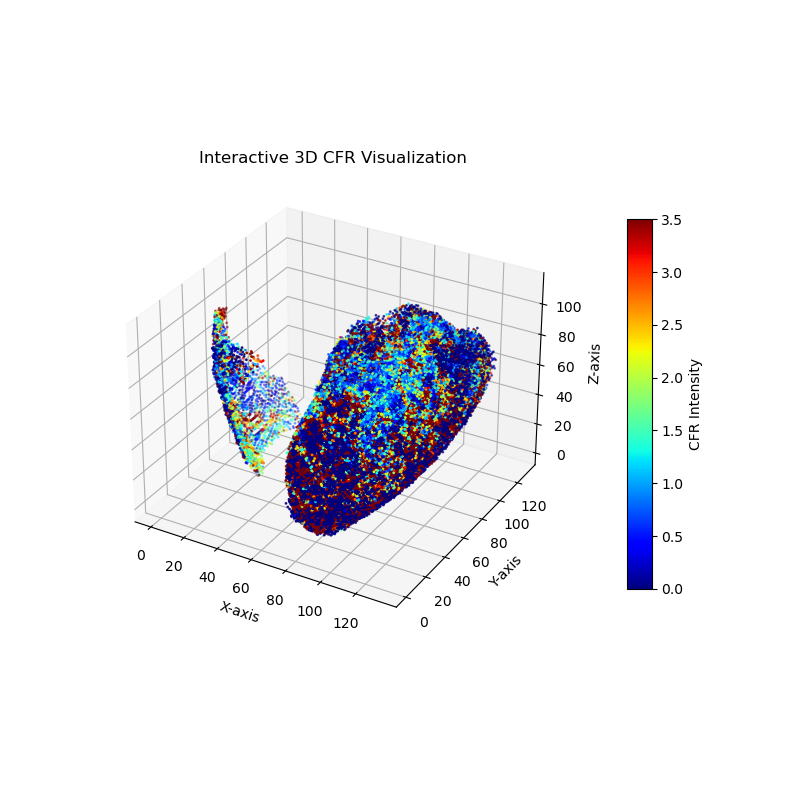

In [363]:
import matplotlib
box = find_bounding_box(dcm_mask_rest[:])
CFR_crop = crop_array(CFR_map, box)
def plot3d(CFR_crop, vmax = 3.5, sample_rate = 5):
    matplotlib.use('module://ipympl.backend_nbagg')
    %matplotlib widget
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    x, y, z = np.indices(CFR_crop.shape)

    # Filter the coordinates and CFR values using the mask
    mask_indices = CFR_crop[:].nonzero()
    x_masked = x[mask_indices]
    y_masked = y[mask_indices]
    z_masked = z[mask_indices]
    CFR_masked = CFR_crop[mask_indices]

    x_masked = x_masked[::sample_rate]
    y_masked = y_masked[::sample_rate]
    z_masked = z_masked[::sample_rate]
    CFR_masked = CFR_masked[::sample_rate]

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_title("Interactive 3D CFR Visualization")
    # Plot only the masked values
    scatter = ax.scatter(
        x_masked,
        y_masked,
        z_masked,
        c=CFR_masked,
        cmap="jet",
        vmin=0,
        vmax=vmax,
        s=1
    )

    # Add a colorbar and adjust its position
    colorbar = fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=15, pad=0.1)
    colorbar.set_label("CFR Intensity")
    plt.show()

plot3d(CFR_crop)